## Toxic Comment Classification Bidirectional LSTM 

In this notebook I will be using Bidrectional LSTM for Toxic Comment Classification. This notebook follows the same template as 1-D CNN and LSTM but I will be using BLSTM instead.  

### The Data 

The data consists of a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are
 - toxic
 - severe_toxic
 - obscene
 - threat 
 - insult
 - identity_hate 
 
The levels of toxicity are multiple labels that we need to classify. The link to data is given below 

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Here, I will be using pre-trained Glove word embeddings from Stanford which can be downloaded from the following link. 

http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# Mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = "//content//gdrive//My Drive//AI School Class//"
import os
os.path.isdir(path)   

True

### Basic Imports 

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import LSTM,Embedding,Bidirectional
from keras.models import Model
from sklearn.metrics import roc_auc_score

### Constants 

In [ ]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100 # pre-trained embeddings only come in specific sizes, so we can only use 50,100,200 or 300
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [ ]:
EmbeddingPath = path + "Word Embedding Data//"
os.path.isdir(EmbeddingPath)

True

### Loading Word Embeddings 

In [ ]:
word2vec = {}
with open(os.path.join(EmbeddingPath + 'glove.6B.100d.txt'),encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found {} word vectors.'.format(len(word2vec)))

Found 400000 word vectors.


In [ ]:
print(word2vec['school'])

[ 0.80336    0.51195   -0.58513   -0.16546   -0.65033    0.55772
 -0.051099   1.0536    -0.45597    1.0997    -0.19709   -0.69005
  0.2634     1.0464    -0.31459   -0.41741    0.7036     0.27429
 -0.79007    0.46717   -0.92044    0.041713   0.75599   -0.13162
 -0.30481   -0.5513    -0.54436   -1.1833    -0.79556    0.55663
 -0.76105    0.8459     0.30398    0.5447    -0.72929    0.11762
 -0.70917    0.26656   -0.06753    0.053805  -0.87024    0.19024
 -0.59956   -0.46065    0.17753    0.22736    0.40392    0.26203
  0.46493   -0.099527  -0.50003   -1.0067    -0.35254    0.27211
 -0.39462   -3.0186     0.46466   -0.63553    1.6931     0.078175
 -0.049976   0.47524    0.13094    0.098022  -0.0098746 -0.68214
  0.49468    0.11997    0.34533    1.0207    -0.26943   -0.195
 -0.063351  -0.13269   -0.41522    0.49386    0.44739    0.51464
 -0.71938   -1.0296    -0.055796   0.34624   -0.37473   -0.90457
 -1.1705    -0.027685  -0.39492   -1.1926     0.38333    0.070544
 -0.4583    -0.33669    0

In [ ]:
dist = np.linalg.norm(word2vec['mother'] - word2vec['father'])
dist

3.047947

In [ ]:
dist = np.linalg.norm(word2vec['mother'] - word2vec['child'])
dist

3.8879817

In [ ]:
dist = np.linalg.norm(word2vec['study'] - word2vec['learn'])
dist

5.258319

In [ ]:
dist = np.linalg.norm(word2vec['study'] - word2vec['studied'])
dist

4.36827

### Loading Data

In [ ]:
DataPath = path + "Toxic Data//"
data_train = pd.read_csv(DataPath + 'train.csv')

In [ ]:
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
data_train.shape

(159571, 8)

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


### Seprating comments from the data frame

In [ ]:
comments = data_train['comment_text'].fillna('Dummy_Value').values

In [ ]:
comments.shape

(159571,)

In [ ]:
type(comments)

numpy.ndarray

### Creating labes for the multi-label classification 

In [ ]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [ ]:
list(data_train.columns)[1:]

['comment_text',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']

In [ ]:
targets = data_train[labels].values

In [ ]:
# targets shape : (Num of Samples,Num of target labels)
targets.shape

(159571, 6)

In [ ]:
targets

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
comments

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

### Printing out some information about the comments

In [ ]:
print('Max Sentence Length : ', max(len(sentence) for sentence in  comments))

Max Sentence Length :  5000


In [ ]:
print('Min Sentence Lenth :', min(len(sentence) for sentence in comments))

Min Sentence Lenth : 6


In [ ]:
sorted_comments = sorted(len(sentensce) for sentensce in comments)
print('Median Sentence Lenth :', sorted_comments[len(sorted_comments)//2])

Median Sentence Lenth : 205


### Tokenizing 

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

In [ ]:
tokenizer.fit_on_texts(comments)

In [ ]:
sequences = tokenizer.texts_to_sequences(comments)

In [ ]:
print(sequences[0])

[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


In [ ]:
len(sequences)

159571

In [ ]:
comments[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
print("Max sequence length:", max(len(s) for s in sequences))

Max sequence length: 1400


In [ ]:
print("Max sequence length:", min(len(s) for s in sequences))

Max sequence length: 0


In [ ]:
sorted_seq = sorted(len(s) for s in sequences)
print("Median sequence length:", sorted_seq[len(sorted_seq) // 2])

Median sequence length: 35


###  Word to Integer mapping

In [ ]:
word2idx = tokenizer.word_index

In [ ]:
word2idx

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

In [ ]:
print('Number of Unique tokens are : {}'.format(len(word2idx)) ) 
# We actually have more words than the MAX_VOCAB_SIZE!!

Number of Unique tokens are : 210337


In [ ]:
MAX_VOCAB_SIZE

20000

In [ ]:
MAX_VOCAB_SIZE

20000

In [ ]:
MAX_SEQUENCE_LENGTH

100

### Padding 

In [ ]:
pad_data = pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
pad_data

array([[    0,     0,     0, ...,  4583,  2273,   985],
       [    0,     0,     0, ...,   589,  8377,   182],
       [    0,     0,     0, ...,     1,   737,   468],
       ...,
       [    0,     0,     0, ...,  3509, 13675,  4528],
       [    0,     0,     0, ...,   151,    34,    11],
       [    0,     0,     0, ...,  1627,  2056,    88]], dtype=int32)

In [ ]:
len(pad_data)

159571

In [ ]:
# Note that the 0 axis is same as comments, just added a new padding dimension which is equal to MAX_SEQUENCE_LENGTH . 
# Padded tensor shape : (Num of Samples,MAX_SEQUENCE_LENGTH)

print('Shape of Padded Tensor: {}'.format(pad_data.shape)) 

Shape of Padded Tensor: (159571, 100)


### Prepare embedding matrix

In [ ]:
# This truncates the word embeddings to MAX_VOCAB_SIZE, +1 is to take care of a little indexing problem.

# In Keras 0 is reserved just for padding, so the indexing starts at 1. 

# Since, python index starts at 0, that +1 takes care of any indexing miss matching. 

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1) 

In [ ]:
num_words

20000

In [ ]:
EMBEDDING_DIM

100

In [ ]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [ ]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
embedding_matrix.shape
# We have successfuly trucnated and created an embedding matrix of dimension (MAX_VOCAB_SIZE,EMBEDDING_DIM )
# Now we have to index it using the words from the pre-trained word2vec to create pre-trained embedding matrix 

(20000, 100)

In [ ]:
for word,i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector    

In [ ]:
embedding_matrix[2]

array([-1.89700007e-01,  5.00239991e-02,  1.90840006e-01, -4.91839983e-02,
       -8.97369981e-02,  2.10060000e-01, -5.49520016e-01,  9.83769968e-02,
       -2.01350003e-01,  3.42409998e-01, -9.26769972e-02,  1.60999998e-01,
       -1.32679999e-01, -2.81599998e-01,  1.87370002e-01, -4.29589987e-01,
        9.60389972e-01,  1.39719993e-01, -1.07809997e+00,  4.05180007e-01,
        5.05389988e-01, -5.50639987e-01,  4.84400004e-01,  3.80439997e-01,
       -2.90549989e-03, -3.49420011e-01, -9.96960029e-02, -7.83680022e-01,
        1.03629994e+00, -2.31399998e-01, -4.71210003e-01,  5.71259975e-01,
       -2.14540005e-01,  3.59580010e-01, -4.83190000e-01,  1.08749998e+00,
        2.85239995e-01,  1.24470003e-01, -3.92480008e-02, -7.67320022e-02,
       -7.63429999e-01, -3.24090004e-01, -5.74899971e-01, -1.08930004e+00,
       -4.18110013e-01,  4.51200008e-01,  1.21119998e-01, -5.13670027e-01,
       -1.33489996e-01, -1.13779998e+00, -2.87680000e-01,  1.67740002e-01,
        5.58040023e-01,  

### Loading pre-trained word embeddings into an Embedding layer

In [ ]:
embedding_layer = Embedding(input_dim=num_words,output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=False)

### Buiding the Model 

In [ ]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))

x = embedding_layer(input_)
x = Bidirectional(LSTM(20, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x) # Grabs the maximum value from the entire seqence 
output = Dense(len(labels), activation='sigmoid')(x)

In [ ]:
model = Model(input_,output)

In [ ]:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 40)           19360     
_________________________________________________________________
global_max_pooling1d (Global (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 2,019,606
Trainable params: 19,606
Non-trainable params: 2,000,000
_________________________________________________________________
None


In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Training 

In [ ]:
trained_model = model.fit(pad_data,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT)

Epoch 1/5
998/998 [==============================] - 72s 72ms/step - loss: 0.0479 - accuracy: 0.9882 - val_loss: 0.0501 - val_accuracy: 0.9864
Epoch 2/5
998/998 [==============================] - 71s 71ms/step - loss: 0.0468 - accuracy: 0.9845 - val_loss: 0.0496 - val_accuracy: 0.9873
Epoch 3/5
150/998 [===>..........................] - ETA: 54s - loss: 0.0465 - accuracy: 0.9788

KeyboardInterrupt: ignored

In [ ]:
# save
model.save(path + 'Transfer Learning Models/Toxic_LSTM.h5')

In [ ]:
# load
from keras.models import load_model, model_from_json
trained_model = load_model(path + 'Transfer Learning Models/Toxic_LSTM.h5')

In [ ]:
print(trained_model.history)

None


### Plotting Accuracy

In [ ]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

TypeError: ignored

#### Not a lot of change here

### Plotting Loss

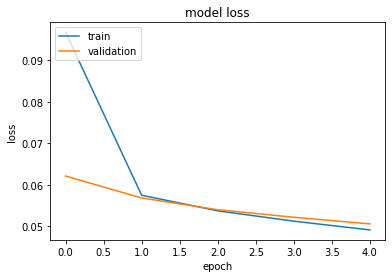

In [ ]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

#### Same here as well 

### Plotting mean AUC over each label

In [ ]:
pred = model.predict(pad_data)

In [ ]:
auc_accuracy = []
for i in range(len(labels)):
    auc = roc_auc_score(targets[:,i], pred[:,i])
    auc_accuracy.append(auc)
print('Mean AUC score for all labels:',np.mean(auc_accuracy))

Mean AUC score for all labels: 0.9779559475281635
